In [ ]:
# https://docs.pymc.io/notebooks/rugby_analytics.html

In [1]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

In [2]:
try:
    df_all = pd.read_csv('../datasets/rugby/rugby.csv')
except:
    df_all = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)

In [3]:
df_all.head()

,home_team,away_team,home_score,away_score,year
0,Wales,Italy,23,15,2014
1,France,England,26,24,2014
2,Ireland,Scotland,28,6,2014
3,Ireland,Wales,26,3,2014
4,Scotland,England,0,20,2014


In [4]:
df_all.describe()

,home_score,away_score,year
count,60.000000,60.000000,60.000000
mean,23.500000,19.983333,2015.500000
std,14.019962,12.911028,1.127469
min,0.000000,0.000000,2014.000000
25%,16.000000,10.000000,2014.750000
50%,20.500000,18.000000,2015.500000
75%,27.250000,23.250000,2016.250000
max,67.000000,63.000000,2017.000000


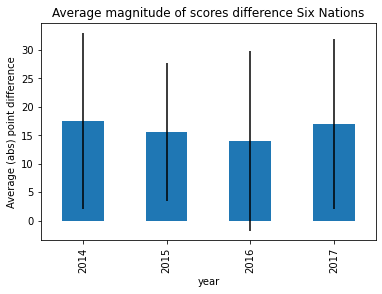

In [5]:
# Looking at the scores by year
df_all['difference'] = np.abs(df_all['home_score']-df_all['away_score'])

(df_all.groupby('year')['difference']
      .mean()

      .plot(kind='bar', title='Average magnitude of scores difference Six Nations', yerr=df_all.groupby('year')['difference'].std())
      .set_ylabel('Average (abs) point difference'));

In [6]:
# seeing this now country by country

df_all['difference_non_abs']=df_all['home_score']-df_all['away_score']

df_all.pivot_table('difference_non_abs', 'home_team', 'year')

year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


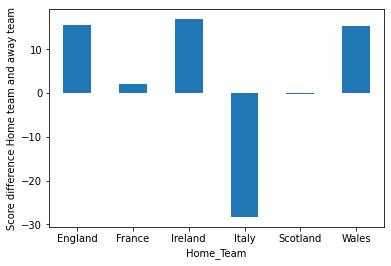

In [7]:
# and for each team without the year 

(df_all.pivot_table('difference_non_abs', 'home_team')
      .rename_axis("Home_Team")
      .plot(kind='bar', rot=0, legend=False)
      .set_ylabel('Score difference Home team and away team')
);


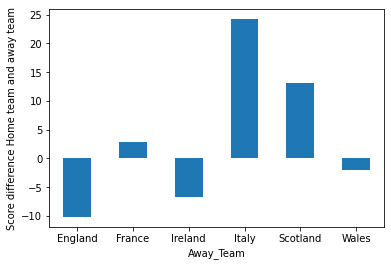

In [8]:
(df_all.pivot_table('difference_non_abs', 'away_team')
      .rename_axis("Away_Team")
      .plot(kind='bar', rot=0, legend=False)
      .set_ylabel('Score difference Home team and away team')
);


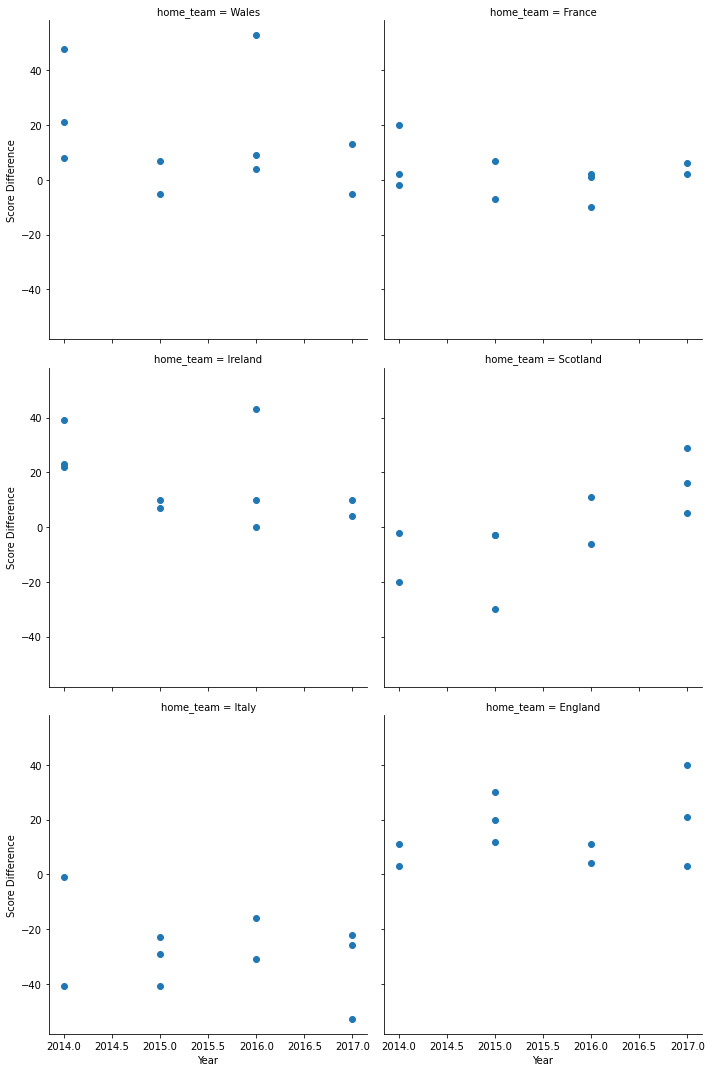

In [9]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, height=5)
g = g.map(plt.scatter, "year", "difference_non_abs").set_axis_labels("Year", "Score Difference")

## Building the model

In [10]:
df = df_all[['home_team', 'away_team', 'home_score', 'away_score']]

teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

In [11]:

with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 3 chains, 0 divergences: 100%|██████████| 6000/6000 [00:23<00:00, 259.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


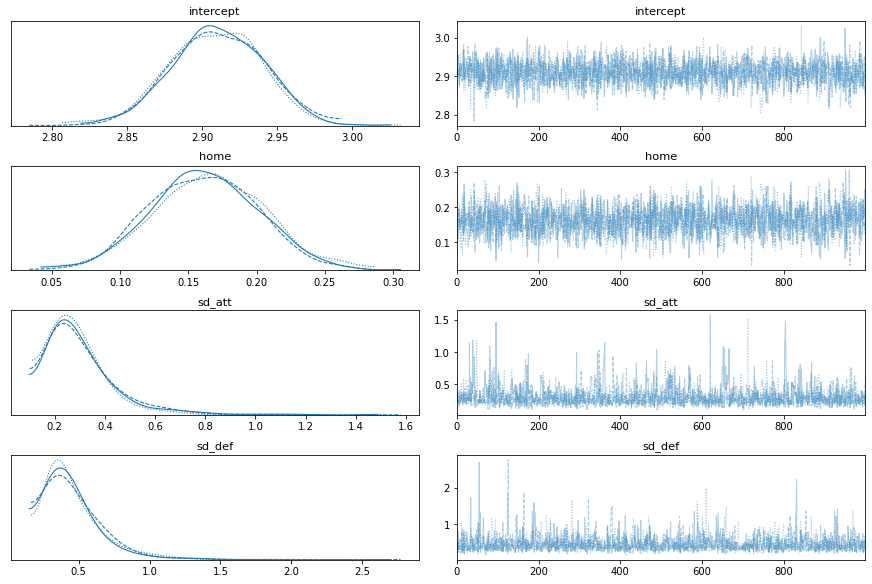

In [12]:
with model:
    trace = pm.sample(1000, tune=1000, cores=3)

pm.traceplot(trace, var_names=['intercept', 'home', 'sd_att', 'sd_def']);

/home/kathuman/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


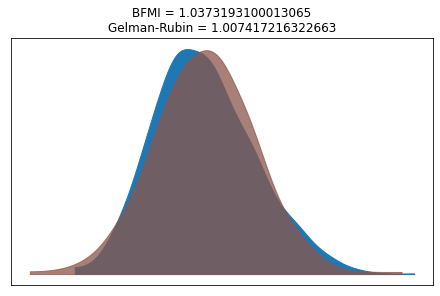

In [13]:
# Applying metrics to see if there is convergence

bfmi = np.max(pm.stats.bfmi(trace))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.gelman_rubin(trace).values()).values

(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

In [14]:
pm.stats.hpd(trace['atts'])

array([[ 0.09599832,  0.24798865],
       [-0.17285622, -0.00096848],
       [ 0.03334729,  0.18781308],
       [-0.20168513, -0.026747  ],
       [-0.44716228, -0.23526005],
       [ 0.17991211,  0.33205583]])

In [15]:
np.quantile(trace['atts'], 0.5, axis=0)

array([ 0.17323435, -0.08518656,  0.10789104, -0.114249  , -0.33671793,
        0.25634784])

## Results

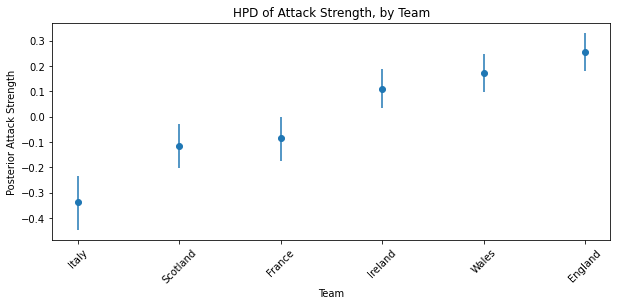

In [16]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(np.quantile(trace['atts'], 0.5, axis=0),
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)